# Ch `08`: Concept `01` Reinforcement learning

## Practical explanation

### Introduction
RL is about training a NN to be able to decide on an action based on the best chances to get a reward. This reward doesn't need to be immediate, i.e. it can anticipate long term changes and adapt to gain long-term rewards rather than short-term. 


### Algorithm

#### Step 1 - Initialize
Initialise algorithm so that there is an initial state. In our example the state is a vector with the prices of stocks over a time period (in the "past"), the available budget and the number of shares we have bought. 

\begin{equation*}
\mathbf{state} =   \begin{pmatrix}
  price_{1} \\
  price_{2} \\
  \vdots \\
  price_{n} \\
  budget  \\
  share_{number}
 \end{pmatrix}
\end{equation*}

The size of the time period in the past that we are going to consider is a hyperparameter that determines the size of $\mathbf{state}$.

In the code the state is initialised in function `run_simulation`

```python
current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))

```
#### Step 2 - Select action
Selection action to perform. The action is selected either randomly or using the NN model. In the start of algorithm steps we want to do more `exploration` rather than `exploitation` since at first our model will not know that much.

This step is performed in the `select_action` method

```python
def select_action(self, current_state, step):
    threshold = min(self.epsilon, step / 1000.)
    if random.random() < threshold:
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
        action_idx = np.argmax(action_q_vals)
        action = self.actions[action_idx]
    else:
        action = self.actions[random.randint(0, len(self.actions) - 1)]
    return action
```

The important code line is `action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})` here we run our state through the NN model and get back the `relu` activation values. These are trained to predict the `utility` of each action, which is our `reward` taking into account long-term rewards. `action_q_vals` is a vector with size equal to the size of our actions. So each element represents the potential `utility` of taking an action. We take the action that can maximize the `utility` using `action_idx = np.argmax(action_q_vals)`.

#### Step 3 - Calculate new state

Based on the results of step 2, we take an action. In the case of our example it's either `sell`, `buy`, `hold`. So if the action is to `buy` we buy the stock at it's current share value, which is not part of the $\mathbf{state}$. 

$current_{value}=price_{n+1}$.

We calculate the new state based on our action.

\begin{equation*}
\mathbf{state_{new}} =   \begin{pmatrix}
  price_{2} \\
  price_{3} \\
  \vdots \\
  price_{n+1} \\
  budget_{new}  \\
  share_{number_{new}}
 \end{pmatrix}
\end{equation*}

#### Step 4 - Calculate reward

Now we calculate our `reward`, this is our immediate gain.

$reward=(budget_{new}+share_{number_{new}} \times current_{value}) - (budget_{old}+share_{number_{old}} \times current_{value})$

#### Step 5 - Correct utility of current action

Based on $\mathbf{state_{old}}$ and $\mathbf{state_{new}}$ we update our `policy`. This is the part we train the NN model. 

This step takes place in the `update_q` function
```python
    def update_q(self, state, action, reward, next_state, writer, i):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_best_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + \
                                self.gamma * next_action_q_vals[0, next_best_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        _, lossSumm = self.sess.run([self.train_op, self.loss_summary], 
                                    feed_dict={self.x: state, self.y: action_q_vals})
```

We get our current `utility` function values for each action using `action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})`(this is done in the `select_action` function also). 

Then using our calculated $\mathbf{state_{new}}$ we get the `utility` function values for each action based on our new state, which depends on the previous state: `next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})`

We calculate, based on the utility function values, which is the best **next action** to take: `next_best_action_idx = np.argmax(next_action_q_vals)`. This allows to "correct" the reward of our **current action** based on long term consequences.

The correction is performed using the following equation:

\begin{equation*}
utility_{current} =  reward + \gamma \times utility_{next}
\end{equation*}

**Note that this changes the utility of the current action only, so only an element of the `action_q_vals`**

If $\gamma$ is zero then we don't take into account long term consequences of our actions. 
This equation is implemented by `action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_best_action_idx]`.

We could also generalize and take into account more actions than just the next, i.e. the one after next etc.

\begin{equation*}
utility_{0} =  reward + \gamma_{1} \times utility_{1} + \gamma_{2} \times utility_{2} +... + \gamma_{k} \times utility_{k}
\end{equation*}

There is also another equation that intoduces another parameter $\alpha$, which aims to make newly available information less/more important than historical records.

\begin{equation*}
utility_{current} =  (1-\alpha) \times utility_{current}+\alpha \times (reward + \gamma \times utility_{next})
\end{equation*}

If $\alpha$ is increased then we expect our `agent` (the decision maker) to learn to solve tasks faster but not optimal.If $\alpha$ is decreased our `agent` is allowed more time to explore and exploit. 

#### Step 6 - Train NN model

Now we train our NN based on the input, our current state `state` and the corrected `utility` values of our current action that takes into account future consequences.

The training call is in function `_, lossSumm = self.sess.run([self.train_op, self.loss_summary],feed_dict={self.x: state, self.y: action_q_vals})`. This will update our NN model parameters so that our state produces `relu` activations that better agree with the corrected utility values of our current action `action_q_vals`, rather than the original that were derived from the same input `state`.



## Code

The **states** are previous history of stock prices, current budget, and current number of shares of a stock.

The **actions** are buy, sell, or hold (i.e. do nothing).

The stock market data comes from the Yahoo Finance library, `pip install yahoo-finance`.

In [1]:
%matplotlib inline
from yahoo_finance import Share
from matplotlib import pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tqdm
import datetime as dt

Define an abstract class called `DecisionPolicy`:

In [2]:
# it's a good idea to create a class with the relevant methods to
# reference later, such as an abstract class or interface
class DecisionPolicy:
    # Basically, reinforcement learning needs two operations well defined:
    def select_action(self, current_state, step):
        # (1) how to select an action
        pass

    def update_q(self, state, action, reward, next_state):
        # (2) how to improve the utility Q-function
        pass

Here's one way we could implement the decision policy, called a random decision policy:

In [3]:
# let's inherit from `DecisionPolicy` superclass to implement a random decision policy
# it's a good idea to test our poly against a random policy or a "greedy" policy (not implemented) that 
# just takes the action that maximizes current reward
class RandomDecisionPolicy(DecisionPolicy):# Inherit from DecisionPolicy to implement its functions
    def __init__(self, actions):
        self.actions = actions

    def select_action(self, current_state, step):
        # Randomly choose the next action
        action = random.choice(self.actions)
        return action

That's a good baseline. Now let's use a smarter approach using a neural network:

In [4]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        # Set the hyper-parameters from the Q-function
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        # Set the number of hidden nodes in the neural networks
        h1_dim = 20
        # Define the input and output tensors
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        # Design the neural network architecture
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        # Define the op to compute the utility
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)
        # Set the loss as the square error
        self.loss = tf.square(self.y - self.q)
        # set loss summary for tensorboard
        self.loss_summary = tf.summary.scalar('loss', tf.reduce_mean(self.loss))
        # Use an optimizer to update model parameters to minimize the loss
        self.train_op = tf.train.AdagradOptimizer(0.01).minimize(self.loss)
        # Set up the session and initialize variables
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())


    def select_action(self, current_state, step):
        # select minimum between epsilon and step/1000 because
        # at the begining we want to explore so that our algorithm learns
        # before it can make policies
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # Exploit best option with probability epsilon
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)  # TODO: replace w/ tensorflow's argmax
            action = self.actions[action_idx]
        else:
            # Explore random option with probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    def update_q(self, state, action, reward, next_state, writer, i):
        """Update the Q-function by updating its model parameters"""
        # calculate utilities of each action for current state
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        # calculate utilities of each action for next state
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        # find next action that will maximise the utility when we are in the next state
        next_best_action_idx = np.argmax(next_action_q_vals)
        # find index of current action
        current_action_idx = self.actions.index(action)
        # now we need to "correct" the utility of current action by looking at the utility of next best action
        # conditional on the current state. In other words the next state depends on the current state.
        # the higher the gamma hyperparameter the more we take into account future rewards for current actions
        # if gamma is zero then we ignore any long term rewards (consequences of our actions)
        # I guess we could add more future states and best actions to make our algorithm better at long term actions
        # i.e. action_q_vals[0, current_action_idx] = reward + self.gamma1 * next_action_q_vals[0, next_best_action_idx]
        # + self.gamma2 * next_next_action_q_vals[0, next_next_best_action_idx]
        action_q_vals[0, current_action_idx] = reward + \
                                               self.gamma * next_action_q_vals[0, next_best_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        # have the nn learn a function that minimizes the difference between the 
        # current uncorrected action and the corrected
        # ones based on future consequences
        _, lossSumm = self.sess.run([self.train_op, self.loss_summary], 
                                    feed_dict={self.x: state, self.y: action_q_vals})
        writer.add_summary(summary=lossSumm, global_step=i)
        writer.add_graph(self.sess.graph)
        writer.flush()

Define a function to run a simulation of buying and selling stocks from a market:

In [5]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, writer):
    # Initialize values that depend on computing the net worth of a portfolio
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in tqdm.tqdm(range(len(prices) - hist - 1)):
        # The state is a `hist+2` dimensional vector. We’ll force it to by a numpy matrix.
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        # Calculate the portfolio value
        current_portfolio = budget + num_stocks * share_value
        # Select an action from the current policy
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        # Update portfolio values based on action
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        # Compute new portfolio value after taking action
        new_portfolio = budget + num_stocks * share_value
        # Compute the reward from taking an action at a state
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        # Update the policy after experiencing a new action
        # This is when we train our model
        policy.update_q(current_state, action, reward, next_state, writer, i)
    # Compute final portfolio worth
    portfolio = budget + num_stocks * share_value
    return portfolio

We want to run simulations multiple times and average out the performances:

In [6]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    # Decide number of times to re-run the simulations
    num_tries = 3
    # Store portfolio worth of each run in this array
    final_portfolios = list()
    # initial portfolio value
    portfolio = budget
    for i in range(num_tries):
        # tensorboard writer
        # *** TENSORBOARD ***
        # set directory to collect saved summary tensors with each run
        # based on run time
        now = dt.datetime.now()
        currentDir = "./logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"
        # create writer and set directory and graph
        writer = tf.summary.FileWriter(currentDir)
        print('Running simulation {}...'.format(i + 1))
        print('Starting budget portfolio: ${}'.format(portfolio))
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist, writer)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
        writer.close()
    # Average the values from all the runs
    avg, std = np.mean(final_portfolios), np.std(final_portfolios)
    return avg, std

Call the following function to use the Yahoo Finance library and obtain useful stockmarket data. 

In [7]:
def get_prices(share_symbol, start_date, end_date, cache_filename='stock_prices.npy'):
    try:
        stock_prices = np.load(cache_filename)
    except IOError:
        share = Share(share_symbol)
        stock_hist = share.get_historical(start_date, end_date)
        stock_prices = [stock_price['Open'] for stock_price in stock_hist]
        np.save(cache_filename, stock_prices)

    return stock_prices.astype(float)

Who wants to deal with stock market data without looking a pretty plots? No one. So we need this out of law:

In [8]:
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')
    plt.show()

Train a reinforcement learning policy:

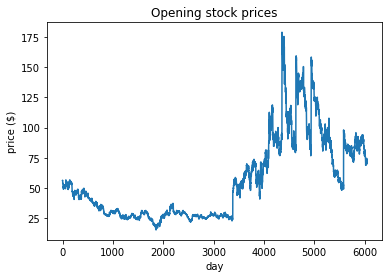

  0%|          | 14/5846 [00:00<00:42, 135.67it/s]

Running simulation 1...
Starting budget portfolio: $1000.0


  0%|          | 19/5846 [00:00<00:30, 188.74it/s]

Final portfolio: $1573.7650420000004
Running simulation 2...
Starting budget portfolio: $1000.0


  0%|          | 21/5846 [00:00<00:27, 209.27it/s]

Final portfolio: $1617.4550170000002
Running simulation 3...
Starting budget portfolio: $1000.0


100%|██████████| 5846/5846 [00:36<00:00, 160.76it/s]

Final portfolio: $1620.3799610000003


In [9]:
if __name__ == '__main__':
    prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
    plot_prices(prices)
    # Define the list of actions the agent can take
    actions = ['Buy', 'Sell', 'Hold']
    hist = 200
    # Initial a random decision policy
    # policy = RandomDecisionPolicy(actions)
    policy = QLearningDecisionPolicy(actions, hist + 2)
    # Set the initial amount of money available to use
    budget = 1000.0
    # Set the number of stocks already owned
    num_stocks = 0
    # Run simulations multiple times to compute expected value of final net worth
    run_simulations(policy, budget, num_stocks, prices, hist)